# Introduction
This is the first section of the series "Three ways to build deep learning model in tensorflow".<br>
In this section you will learn about the sequential API. This API allows you to build deep learning model <br>
by stacking layers on top of each other. In this example, the task is to classify digits (0, 1, ..., 9).

# Import libraries


In [21]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
from tensorflow.keras.models import Sequential
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from tensorflow.keras.metrics import Recall, Precision, AUC, CategoricalAccuracy
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.layers import Input
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import LambdaCallback
from tensorflow.keras.callbacks import TensorBoard
import warnings
import datetime
warnings.filterwarnings('ignore')
from utility_functions import plt_plot_to_tf_image
from utility_functions import plot_images
from utility_functions import plot_confusion_matrix

%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


# Feedfoward network
The sequential API is perfect in implementing feedforward network also known as multilayers perceptron (MLP).<br>
In a multilayer perceptron (MLP) the input is fed into a series of hidden layers which produce an output: <br>
For example a MLP with 3 hidden layers and one output layer can be written as: <br>
<br>
output = output_layer(layer_3(layer_2(layer_1(input))))

In [2]:
# example 1
# layer_1 = Dense(units=5, activation='relu', name='first_layer')
# layer_2 = Dense(units=5, activation='relu', name='second_layer')
# layer_3 = Dense(units=5, activation='relu', name='third_layer')
# output_layer = Dense(units=1, activation='sigmoid')

# input_x = tf.constant([[1,2,3,5]], name='input_x')
# print(input_x)
# output_y = output_layer(layer_3(layer_2(layer_1(input_x))))
# print(layer_2.units)


# Load the MINIST data set and plot few images


In [3]:
dataset = tf.keras.datasets.mnist
(train_X, train_y), (test_X, test_y) = dataset.load_data()
print('Training data shape ', train_X.shape)
print('Test data shape ', test_X.shape)

Training data shape  (60000, 28, 28)
Test data shape  (10000, 28, 28)


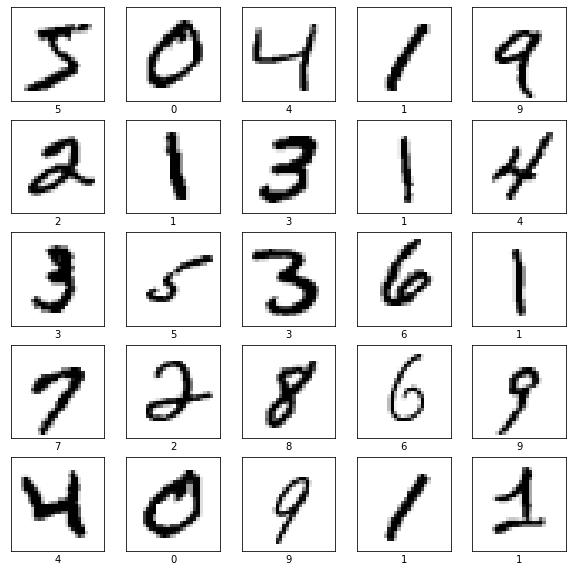

In [4]:
# plot few images images
nb_images = 20
figure = plot_images(nb_images, train_X, train_y)
##

# Build a model with the sequential API

In [5]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
plot_writer = tf.summary.create_file_writer(log_dir)
figure = plot_images(nb_images, train_X, train_y, plot_image=False)
with plot_writer.as_default():
    tf.summary.image('sample hand written digits', plt_plot_to_tf_image(figure), step=0)

In [7]:
# set model parameters
first_layer_units = 128
second_layer_units = 128
output_layer_units = 10

sequential_model = Sequential([
    Flatten(input_shape=(28, 28), name='input_layer'),

    BatchNormalization(),
    Dense(units=first_layer_units, activation='relu', name='first_layer'),
    Dense(units=second_layer_units, activation='relu', name='second_layer'),
    #tf.keras.layers.Dropout(0.2),
    Dense(units=output_layer_units, activation='softmax', name='output_layer')
], name='senquential_classifier')


# # model summary
sequential_model.summary()

Model: "senquential_classifier"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (Flatten)        (None, 784)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 784)               3136      
_________________________________________________________________
first_layer (Dense)          (None, 128)               100480    
_________________________________________________________________
second_layer (Dense)         (None, 128)               16512     
_________________________________________________________________
output_layer (Dense)         (None, 10)                1290      
Total params: 121,418
Trainable params: 119,850
Non-trainable params: 1,568
_________________________________________________________________


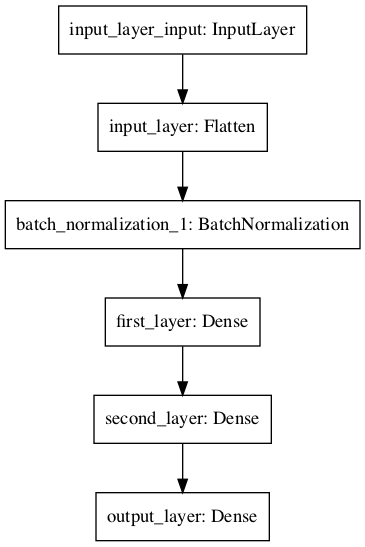

In [8]:
# model architecture plot
plot_model(sequential_model)

# Compile the model

In [9]:
sequential_model.compile(
    loss=SparseCategoricalCrossentropy(from_logits=True),
    optimizer=Adam(learning_rate=0.0001),
    metrics=['accuracy']
)

# Fit the model

In [22]:
# import datetime
# log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")



def log_confusion_matrix(epoch, logs):
    # Use the model to predict the values from the validation dataset.
    test_pred_raw = sequential_model.predict(test_X)
    test_pred = np.argmax(test_pred_raw, axis=1)
    # Calculate the confusion matrix.
    cm = confusion_matrix(test_y, test_pred)
    # Log the confusion matrix as an image summary.
    figure = plot_confusion_matrix(cm, class_names=test_y)
    cm_image = plot_to_image(figure)
    # Log the confusion matrix as an image summary.
    with file_writer_cm.as_default():
        tf.summary.image("Confusion Matrix", cm_image, step=epoch)

# define call back functions
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=2)
confusion_matrix_callback = LambdaCallback(on_epoch_end=log_confusion_matrix)
file_writer_cm = tf.summary.create_file_writer(log_dir + '/cm')

sequential_model.fit(x=train_X, 
                     y=train_y, 
                     epochs=5, 
                     callbacks=[tensorboard_callback, confusion_matrix_callback],
                     validation_data=(test_X, test_y)
                     )
                     


Epoch 1/5
1875/1875 [==============================] - 3s 1ms/step - loss: 0.0872 - accuracy: 0.9732 - val_loss: 0.4158 - val_accuracy: 0.9677


NameError: name 'plot_confusion_matrix' is not defined

In [ ]:
#!tensorboard --logdir=logs/fit --host localhost --port 8089